### Autoencoder + UMAP
This notebook extends the last notebook to train the embedding jointly on the reconstruction loss, and UMAP loss, resulting in slightly better reconstructions, and a slightly modified UMAP embedding. 

### load data

In [4]:
from tensorflow.keras.datasets import mnist
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], -1))/255.
test_images = test_images.reshape((test_images.shape[0], -1))/255.

### define the encoder network

In [ ]:
import tensorflow as tf

In [5]:
dims = (28,28, 1)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 3,549,954
Trainable params: 3,549,954
Non-trainable params: 0
______________________________________________

In [6]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              3217536   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)       

### create parametric umap model

In [7]:
from umap.parametric_umap import ParametricUMAP

In [9]:
embedder = ParametricUMAP(
    encoder=encoder,
    decoder=decoder,
    dims=dims,
    n_training_epochs=1,
    n_components=n_components,
    parametric_reconstruction= True,
    autoencoder_loss = True,
    reconstruction_validation=test_images,
    verbose=True,
)

In [10]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(autoencoder_loss=True, n_training_epochs=5,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f92a05514a8>,
               parametric_reconstruction=True,
               reconstruction_validation=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))
Construct fuzzy simplicial set
Sun Aug 16 18:25:21 2020 Finding Nearest Neighbors
Sun Aug 16 18:25:21 2020 Building RP forest with 17 trees
Sun Aug 16 18:25:25 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Sun Aug 16 18:25:37 2020 Finished Nearest Neighbor Search
Sun Aug 16 18:25:40 2020 Construct embedding
Epoch 1/50
724/724 [==============================] - 14s 19ms/step - loss: 0.4622 - reconstruction_loss: 0.2297 - umap_loss: 0.2325 - val_loss: 0.201

### plot reconstructions

In [16]:
import numpy as np

In [17]:
test_images_recon = embedder.inverse_transform(embedder.transform(test_images))

10/10 [==============================] - 0s 1ms/step


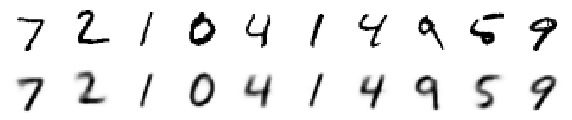

In [18]:
nex = 10
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(nex, 2))
for i in range(nex):
    axs[0, i].matshow(np.squeeze(test_images[i].reshape(28, 28, 1)), cmap=plt.cm.Greys)
    axs[1, i].matshow(
        tf.nn.sigmoid(np.squeeze(test_images_recon[i].reshape(28, 28, 1))),
        cmap=plt.cm.Greys,
    )
for ax in axs.flatten():
    ax.axis("off")

### plot results

In [11]:
embedding = embedder.embedding_

In [12]:
import matplotlib.pyplot as plt

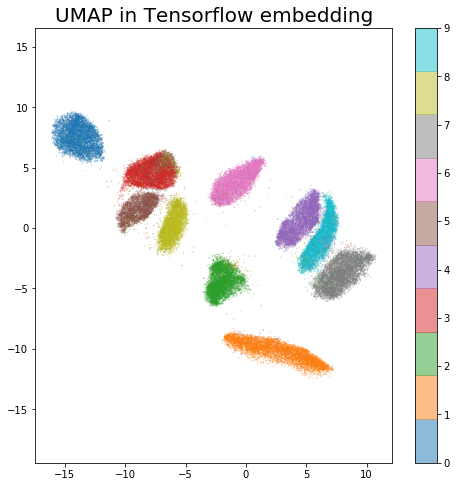

In [13]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### plotting loss

In [19]:
embedder._history.keys()

dict_keys(['loss', 'reconstruction_loss', 'umap_loss', 'val_loss', 'val_reconstruction_loss', 'val_umap_loss'])

Text(0.5, 0, 'Epoch')

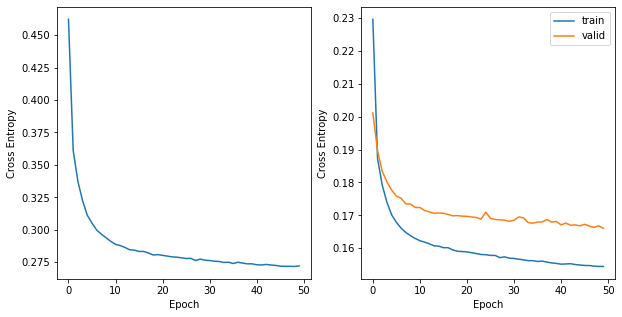

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

ax = axs[1]
ax.plot(embedder._history['reconstruction_loss'], label='train')
ax.plot(embedder._history['val_reconstruction_loss'], label='valid')
ax.legend()
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')